In [0]:
!nvidia-smi

Thu Jun 11 22:43:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

At first we need to load pretrained weights for VGG19.

In [0]:
!wget -c --no-check-certificate https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth
vgg_directory = "/content/vgg_conv.pth"

--2020-06-11 22:43:24--  https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth
Resolving bethgelab.org (bethgelab.org)... 46.38.232.246
Connecting to bethgelab.org (bethgelab.org)|46.38.232.246|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 200 OK
Length: 160198540 (153M) [text/plain]
Saving to: ‘vgg_conv.pth’

vgg_conv.pth        100%[===================>] 152.78M  9.37MB/s    in 17s     

2020-06-11 22:43:41 (9.06 MB/s) - ‘vgg_conv.pth’ saved [160198540/160198540]



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as tutils
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output
from decimal import Decimal
import matplotlib.pyplot as plt
import collections

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## NST Model

The original architecture of the VGG19 CNN is represented by 16 convolutional layers in 5 convolution blocks. At the same time, Gatys et al. note in their paper that using AvgPooling instead of MaxPooling improves the gradient and the resulting images looks more attractive for human.

The authors of the paper made an attempt to visualize information at different CNN layers. The input image was recreated from the first layer of each convolutional block. It was possible to find out that the reconstructed image from the first layers of the first three blocks is near identical to the original. And in last blocks information about individual pixels is going lost, but at the same time, global information about the objects on the image is preserved, i.e. about their shape, relative position, etc.

In addition, the authors made various attempts to recreate the image style. To preserve style information, they computes correlations between the different features in different layers of the CNN, and reconstruct the style of the input image from style representations built on different subsets of CNN layers: 1; 1 and 2; 1-3; 1-4; 1-5. The authors declare that the use of a new additional layer for the reconstruction of the style is increases the scale of drawing an individual attribute, while the information about the relative position of these attributes is get lost.

Thus, the most rational approach for the Style Transfer algorithm is to use a feature map of one of the “upper” CNN layers to transfer content to the resulting image, and use several CNN “deep” layers to transfer the style. The authors of the article used the first layers of all five blocks to preserve the style and one layer of the fourth block to transfer content.

To repeat some experiments described and performed by Gatys et al., let's define a parameterized constructor, for the possibility of creating networks with a different pooling type and a parameterized forward () function, for to be able to determine the outputs of which layers we will use when run NST.

In [0]:
class VGG_nst(nn.Module):
    def __init__(self, pooling=None):
        super(VGG_nst,self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        

        if pooling is 'avg':
            self.pool_1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool_2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool_3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool_4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool_5 = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool_5 = nn.MaxPool2d(kernel_size=2, stride=2)

        
    def forward(self, x, out_layers):
        out = {}
        out['conv1_1'] = F.relu(self.conv1_1(x))
        out['conv1_2'] = F.relu(self.conv1_2(out['conv1_1']))
        out['pool_1'] = self.pool_1(out['conv1_2'])
        
        out['conv2_1'] = F.relu(self.conv2_1(out['pool_1']))
        out['conv2_2'] = F.relu(self.conv2_2(out['conv2_1']))
        out['pool_2'] = self.pool_2(out['conv2_2'])
        
        out['conv3_1'] = F.relu(self.conv3_1(out['pool_2']))
        out['conv3_2'] = F.relu(self.conv3_2(out['conv3_1']))
        out['conv3_3'] = F.relu(self.conv3_3(out['conv3_2']))
        out['conv3_4'] = F.relu(self.conv3_4(out['conv3_3']))
        out['pool_3'] = self.pool_3(out['conv3_4'])
        
        out['conv4_1'] = F.relu(self.conv4_1(out['pool_3']))
        out['conv4_2'] = F.relu(self.conv4_2(out['conv4_1']))
        out['conv4_3'] = F.relu(self.conv4_3(out['conv4_2']))
        out['conv4_4'] = F.relu(self.conv4_4(out['conv4_3']))
        out['pool_4'] = self.pool_4(out['conv4_4'])
        
        out['conv5_1'] = F.relu(self.conv5_1(out['pool_4']))
        out['conv5_2'] = F.relu(self.conv5_2(out['conv5_1']))
        out['conv5_3'] = F.relu(self.conv5_3(out['conv5_2']))
        out['conv5_4'] = F.relu(self.conv5_4(out['conv5_3']))
        out['pool_5'] = self.pool_5(out['conv5_4'])

        return [out[layer] for layer in out_layers]

In [0]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        f = input.reshape(b, c, h*w) #BxCx(HxW)
        # torch.bmm
        # f: [BxCx(HxW)] @ [Bx(HxW)xC] -> [BxCxC]
        G = torch.bmm(f, f.transpose(1, 2))
        return G.div_(h*w)

class StyleLoss(nn.Module):
    def forward(self, input, target):
        GramInput = GramMatrix()(input)
        return nn.MSELoss()(GramInput, target)

## Utils

In [0]:
def preprocess(img, size):
    img = transforms.Resize(size)(img)
    img = transforms.ToTensor()(img)
    img = transforms.Lambda(lambda x:x[torch.LongTensor([2, 1, 0])])(img) #RGB to BGR
    img = transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1, 1, 1])(img) #imagenet mean
    img = transforms.Lambda(lambda x: x.mul_(255))(img)
    return img


def postprocess(img):
    img = transforms.Lambda(lambda x: x.mul_(1./255))(img)
    img = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1,1,1])(img)
    img = transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])])(img) #turn to RGB
    img = img.clamp_(0,1)
    return img


def load_img(path, img_size):
    img = Image.open(path)
    img = preprocess(img, img_size)
    img = img.unsqueeze(0)
    return img.to(device)


def load_raw_img(path):
    image = Image.open(path)
    image_tensor = transforms.ToTensor()(image)
    return image_tensor.unsqueeze(0)


def get_preview(tensor):
    image_tensor = tensor.cpu().clone()
    image = transforms.ToPILImage()(image_tensor.squeeze(0))
    image = transforms.Resize(imsize)(image)
    image = transforms.CenterCrop(imsize)(image)
    return image


def show_intermediate_results(content, styles, output):
    num_styles = len(styles)
    column = 4 if num_styles == 2 else 3
    scale = 6

    clear_output(wait=True)
    
    fig = plt.figure(figsize=(column*scale, scale))
    
    ax1 = plt.subplot(1, column, 1)
    ax1.imshow(get_preview(content))
    ax1.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    ax1.set_title("Content Image")

    ax2 = plt.subplot(1, column, column)
    ax2.imshow(get_preview(output))
    ax2.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    ax2.set_title("Output Image")

    if num_styles <= 2:
        ax3 = plt.subplot(1, column, 2)
        ax3.imshow(get_preview(styles[0][0]))
        ax3.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        if num_styles < 2:
            ax3.set_title("Style Image")
        else:
            ax3.set_title("Style Image: {:.1f}% of total".format(styles[0][1]*100))

    if num_styles == 2:
        ax4 = plt.subplot(1, column, 3)
        ax4.imshow(get_preview(styles[1][0]))
        ax4.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax4.set_title("Second Style Image: {:.1f}% of total".format(styles[1][1]*100))

    if num_styles >= 3:
        ax5 = plt.subplot(2, 6, 3)
        ax5.imshow(get_preview(styles[0][0]))
        ax5.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax5.set_title("Style 1: {:.1f}% of total".format(styles[0][1]*100))
        
        ax6 = plt.subplot(2, 6, 4)
        ax6.imshow(get_preview(styles[1][0]))
        ax6.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax6.set_title("Style 2: {:.1f}% of total".format(styles[1][1]*100))

        ax7 = plt.subplot(2, 6, 9)
        ax7.imshow(get_preview(styles[2][0]))
        ax7.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax7.set_title("Style 3: {:.1f}% of total".format(styles[2][1]*100))

    if num_styles > 3:
        ax8 = plt.subplot(2, 6, 10)
        ax8.imshow(get_preview(styles[3][0]))
        ax8.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax8.set_title("Style 4: {:.1f}% of total".format(styles[3][1]*100))

    plt.show()
    return


def show_styles_and_weights(styles):
    columns = len(styles)
    scale = 4
    fig = plt.figure(figsize=(columns*scale, scale))
    fig.suptitle('These selected styles would be added to output picture:', fontsize=16)
    i = 0
    for path, weight in styles.items():
        ax = plt.subplot(1, columns, i+1)
        ax.imshow(get_preview(load_raw_img(path)))
        ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
        ax.set_title("{:.2f}% of total style".format(weight*100))
        i += 1
    return


def draw_nst_examples(picture_set, ratio_set, layers_set, scale=4):
    nrows = len(layers_set)
    ncols = len(ratio_set)
    i = 0
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*scale, nrows*scale), sharey=True, sharex=True)
    for row in range(nrows):
        for col in range(ncols):
            ax[row, col].imshow(get_preview(picture_set[i]))
            ax[row, col].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
            ax[row, col].set_title("α/β ratio:" + f"{Decimal(ratio_set[col]):.0e}")
            ax[row, col].set_ylabel(str(layers_set[row][-1]))
            i += 1
    return


def draw_pooling_examples(picture_set, pool_set, content_set, scale=4):
    nrows = len(content_set)
    ncols = len(pool_set)
    i = 0
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*scale, nrows*scale), sharey=True, sharex=True)
    for row in range(nrows):
        for col in range(ncols):
            ax[row, col].imshow(get_preview(picture_set[i]))
            ax[row, col].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
            ax[row, col].set_title("Pooling type: " + pool_set[col])
            i += 1
    return


def draw_history_plot(history, content_scale='log'):
    fig, ax = plt.subplots(figsize=(10, 7))
    lines = []
    for layer, losses in history.items():
        if layer.startswith('content'):
            ax2 = ax.twinx()
            line = ax2.plot(range(1, len(losses)+1), losses, label=layer)
            lines += line
            ax2.set_ylabel('Content loss')
            ax2.set_yscale(content_scale)
            continue
        line = ax.plot(range(1, len(losses)+1), losses, label=layer)
        lines += line

    labels = [l.get_label() for l in lines]
    ax.set_yscale('log')
    ax.grid()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Style losses and total loss')
    plt.legend(lines, labels, loc='upper right', framealpha=0.5)
    plt.show()

## Train

In [0]:
def run_style_transfer(model, optim_img, optimizer, iter_num, loss_layers, targets, loss_funcs, weights, verbose=True):
    if verbose:
        style_prev = [(load_raw_img(path), val) for path, val in style_paths.items()]
        content_prev = load_raw_img(content_path)

    history = collections.defaultdict(list)
    for iteration in tqdm(range(iter_num)):
        def closure():
            optimizer.zero_grad()
            out = model(optim_img, loss_layers)
            
            totalLossList = []
            for i in range(len(out)):
                criterion = loss_funcs[i]
                output = out[i]
                target = targets[i]
                weight = weights[i]
                loss = criterion(output, target) * weight
                totalLossList.append(loss)

                # Сохраняем лосс в историю
                if i < (len(out) - 1):
                    prefix = 'style'
                else:
                    prefix = 'content'
                history["{}: {}".format(prefix, loss_layers[i])].append(loss.item())

            total_loss = sum(totalLossList)
            total_loss.backward()
            # Сохраняем лосс в историю
            history['total'].append(total_loss.item())
            return total_loss
        optimizer.step(closure)

        if iteration % 5 == 0 and verbose:
            int_result = postprocess(optim_img.data[0].cpu().squeeze())
            show_intermediate_results(content_prev, style_prev, int_result)

    res_img = postprocess(optim_img.data[0].cpu().squeeze())
    return res_img, history

In [0]:
def normalize_weights(styles_dict):
    total = sum(styles_dict.values())
    for k, v in style_paths.items():
        style_paths[k] = float(v)/total


def get_model(path_to_pretrained, pooling='avg'):
    if pooling != 'avg' and pooling != 'max':
        raise BaseException("Неправильно указан pooling-тип. " +
                            "Допустимые значения: avg, max.")
    model = VGG_nst(pooling)
    model.load_state_dict(torch.load(path_to_pretrained))
    for param in model.parameters():
        param.requires_grad = False
    return model.to(device)


def get_loss_funcs(style_layers, content_layers):
    style_losses = [StyleLoss()] * len(style_layers)
    content_losses = [nn.MSELoss()] * len(content_layers)
    funcs = style_losses + content_losses
    funcs = [f.to(device) for f in funcs]
    return funcs


def get_targets(model, style_layers, content_layers, style_images, content_image):
    style_targets = []
    for img, weight in style_images:
        style_targets.append([GramMatrix()(t).detach() * weight for t in model(img, style_layers)])
    style_targets = [sum(t) for t in zip(*style_targets)]
    content_targets = [t.detach() for t in model(content_image, content_layers)]
    targets = style_targets + content_targets
    return targets

## Transfer style examples

### Single style

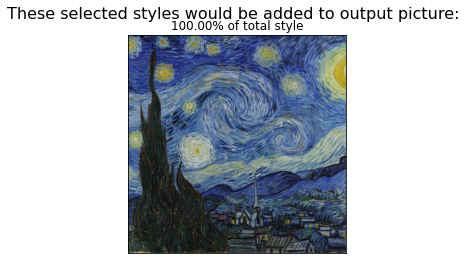

In [0]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layers = ['conv4_2']

content_path = '/content/balley.png'
style_paths = {
               '/content/style_8.jpg': 1,
              }
imsize = 512
normalize_weights(style_paths)
show_styles_and_weights(style_paths)

In [0]:
style_images = [(load_img(path, imsize), relative_weight) for path, relative_weight in style_paths.items()]
content_image = load_img(content_path, imsize)

In [0]:
nst_model = get_model(path_to_pretrained=vgg_directory, pooling='avg')
targets = get_targets(nst_model, style_layers, content_layers, style_images, content_image)
loss_funcs = get_loss_funcs(style_layers, content_layers)
loss_layers = style_layers + content_layers

style_weight = 1e3
content_weight = 1e0
factor = 1. / len(style_layers)
weights = [style_weight * factor] * len(style_layers) + [content_weight] * len(content_layers)

optimImg = Variable(content_image.data.clone(), requires_grad=True).to(device)
optimizer = optim.LBFGS([optimImg])

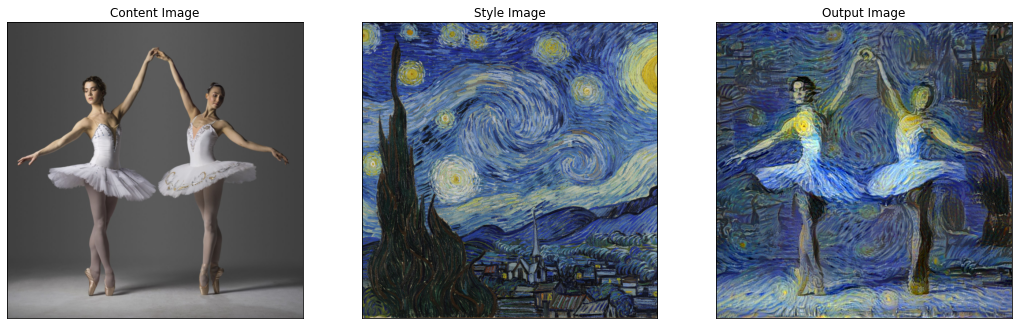

100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


In [0]:
img, h = run_style_transfer(model = nst_model,
                            optim_img = optimImg,
                            optimizer = optimizer,
                            iter_num = 20,
                            loss_layers = loss_layers,
                            targets = targets,
                            loss_funcs = loss_funcs,
                            weights = weights,
                            verbose = True)

In [ ]:
draw_history_plot(h)

### Two styles (fusion)

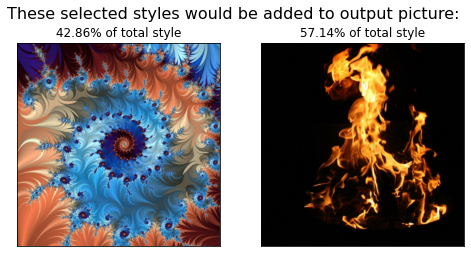

In [0]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layers = ['conv4_2']

content_path = '/content/balley.png'
style_paths = {
               '/content/style_5.jpg': 3,
               '/content/style_4.jpg': 4,
              }
imsize = 512
normalize_weights(style_paths)
show_styles_and_weights(style_paths)

In [0]:
style_images = [(load_img(path, imsize), relative_weight) for path, relative_weight in style_paths.items()]
content_image = load_img(content_path, imsize)

In [0]:
nst_model = get_model(path_to_pretrained=vgg_directory, pooling='avg')
targets = get_targets(nst_model, style_layers, content_layers, style_images, content_image)
loss_funcs = get_loss_funcs(style_layers, content_layers)
loss_layers = style_layers + content_layers

style_weight = 1e3
content_weight = 1e0
factor = 1. / len(style_layers)
weights = [style_weight * factor] * len(style_layers) + [content_weight] * len(content_layers)

optimImg = Variable(content_image.data.clone(), requires_grad=True).to(device)
optimizer = optim.LBFGS([optimImg])

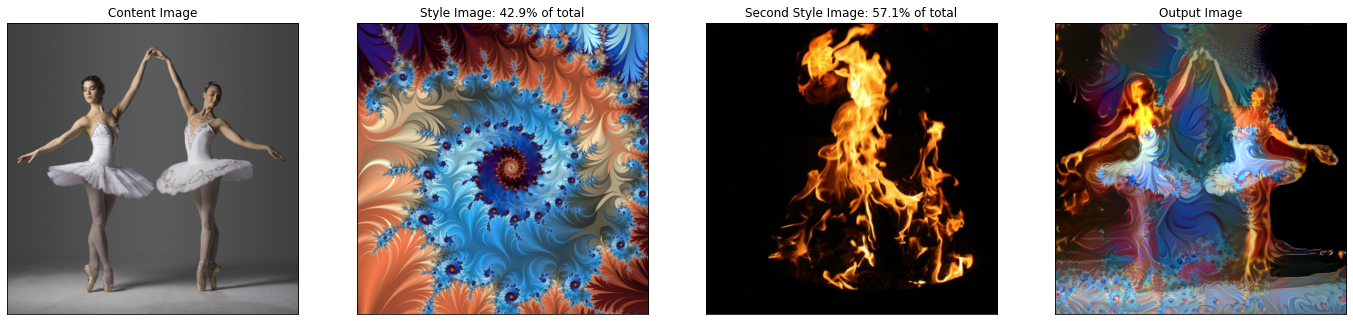

100%|██████████| 20/20 [00:42<00:00,  2.10s/it]


In [0]:
img, h = run_style_transfer(model = nst_model,
                            optim_img = optimImg,
                            optimizer = optimizer,
                            iter_num = 40,
                            loss_layers = loss_layers,
                            targets = targets,
                            loss_funcs = loss_funcs,
                            weights = weights,
                            verbose = True)

### Three styles (fusion)

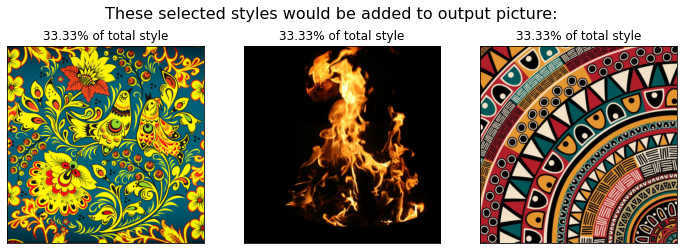

In [0]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layers = ['conv4_2']

content_path = '/content/flower.png'
style_paths = {
               #'/content/0005.jpg': 4,
               '/content/style_10.jpg': 4,
               '/content/style_4.jpg': 4,
               '/content/style_9.jpg': 4,
              }
imsize = 512
normalize_weights(style_paths)
show_styles_and_weights(style_paths)

In [0]:
style_images = [(load_img(path, imsize), relative_weight) for path, relative_weight in style_paths.items()]
content_image = load_img(content_path, imsize)

In [0]:
nst_model = get_model(path_to_pretrained=vgg_directory, pooling='avg')
targets = get_targets(nst_model, style_layers, content_layers, style_images, content_image)
loss_funcs = get_loss_funcs(style_layers, content_layers)
loss_layers = style_layers + content_layers

style_weight = 1e3
content_weight = 1e5
factor = 1. / len(style_layers)
weights = [style_weight * factor] * len(style_layers) + [content_weight] * len(content_layers)

optimImg = Variable(content_image.data.clone(), requires_grad=True).to(device)
optimizer = optim.LBFGS([optimImg])

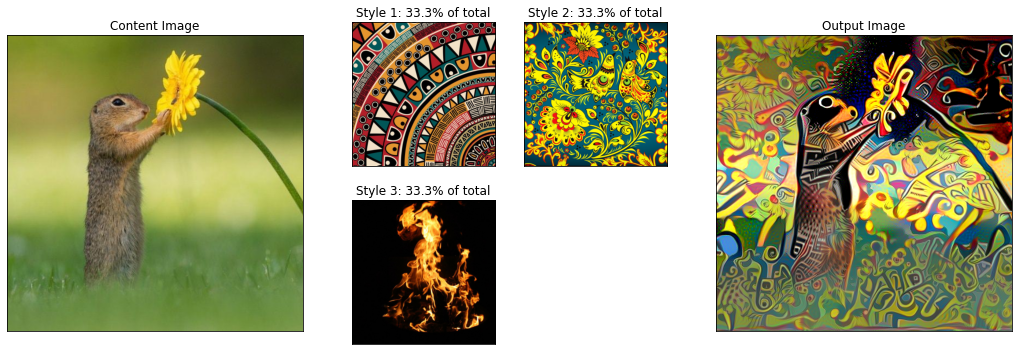

100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


In [0]:
img, h = run_style_transfer(model = nst_model,
                            optim_img = optimImg,
                            optimizer = optimizer,
                            iter_num = 20,
                            loss_layers = loss_layers,
                            targets = targets,
                            loss_funcs = loss_funcs,
                            weights = weights,
                            verbose = True)

### Four styles (fusion)

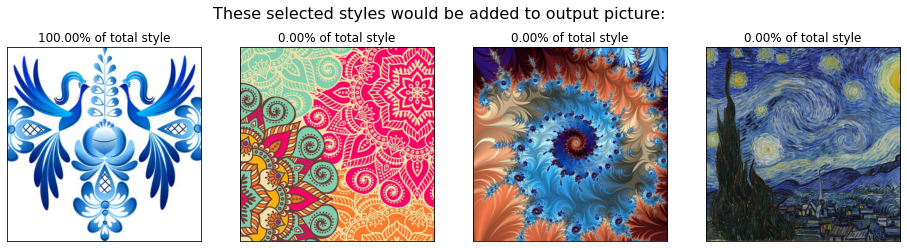

In [0]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layers = ['conv4_2']

content_path = '/content/balley.png'
style_paths = {
               '/content/style_2.jpg': 1,
               '/content/00888.jpg': 0,
               '/content/style_5.jpg': 0,
               '/content/style_8.jpg': 0,
              }
imsize = 512
normalize_weights(style_paths)
show_styles_and_weights(style_paths)

In [0]:
style_images = [(load_img(path, imsize), relative_weight) for path, relative_weight in style_paths.items()]
content_image = load_img(content_path, imsize)

In [0]:
nst_model = get_model(path_to_pretrained=vgg_directory, pooling='avg')
targets = get_targets(nst_model, style_layers, content_layers, style_images, content_image)
loss_funcs = get_loss_funcs(style_layers, content_layers)
loss_layers = style_layers + content_layers

style_weight = 1e3
content_weight = 1e6
factor = 1. / len(style_layers)
weights = [style_weight * factor] * len(style_layers) + [content_weight] * len(content_layers)

optimImg = Variable(content_image.data.clone(), requires_grad=True).to(device)
optimizer = optim.LBFGS([optimImg])

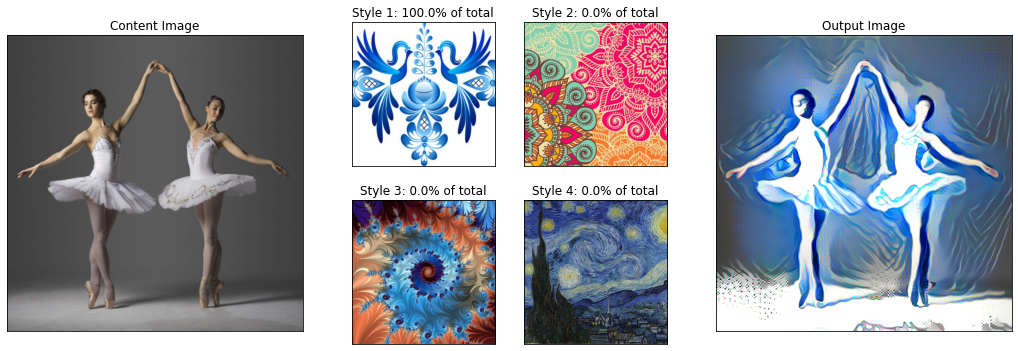

100%|██████████| 50/50 [01:48<00:00,  2.17s/it]


In [0]:
img, h = run_style_transfer(model = nst_model,
                            optim_img = optimImg,
                            optimizer = optimizer,
                            iter_num = 50,
                            loss_layers = loss_layers,
                            targets = targets,
                            loss_funcs = loss_funcs,
                            weights = weights,
                            verbose = True)

## Comparison of different subsets of style layers

The loss function we minimise is

$L_{total}(\vec{p},\vec{a},\vec{x})$ = $\alpha$ $L_{content}(\vec{p},\vec{x})$ + $\beta$ $L_{style}(\vec{a},\vec{x})$

where $\vec{a}$ is style image, $\vec{p}$ is content image, $\vec{x}$ is generated (output) image and
$\alpha$ and $\beta$ are the weighting factors for content and style.

In [0]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layers = ['conv4_2']

alpha_beta_ratios = [1e-5, 1e-3, 1e-1, 1e+1, 1e+3]

In [0]:
style_layers_subsets = [[s for s in style_layers[:i+1]] for i in range(5)]
style_layers_subsets

[['conv1_1'],
 ['conv1_1', 'conv2_1'],
 ['conv1_1', 'conv2_1', 'conv3_1'],
 ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'],
 ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']]

In [0]:
style_content_weights_sets = [(1/ratio, 1) for ratio in alpha_beta_ratios]
style_content_weights_sets

[(99999.99999999999, 1), (1000.0, 1), (10.0, 1), (0.1, 1), (0.001, 1)]

In [0]:
pics = []

for layers_set in style_layers_subsets:
    for weights_set in style_content_weights_sets:
        style_layers = layers_set
        content_layers = ['conv4_2']

        content_path = '/content/balley.png'
        style_paths = { '/content/style_9.jpg': 1 }
        normalize_weights(style_paths)

        imsize = 512
        style_images = [(load_img(path, imsize), relative_weight) for path, relative_weight in style_paths.items()]
        content_image = load_img(content_path, imsize)

        nst_model = get_model(path_to_pretrained=vgg_directory, pooling='avg')
        targets = get_targets(nst_model, style_layers, content_layers, style_images, content_image)
        loss_funcs = get_loss_funcs(style_layers, content_layers)
        loss_layers = style_layers + content_layers

        style_weight, content_weight = weights_set
        factor = 1. / len(style_layers)
        weights = [style_weight * factor] * len(style_layers) + [content_weight] * len(content_layers)

        optimImg = Variable(content_image.data.clone(), requires_grad=True).to(device)
        optimizer = optim.LBFGS([optimImg])

        img, h = run_style_transfer(model = nst_model,
                   optim_img = optimImg,
                   optimizer = optimizer,
                   iter_num = 20,
                   loss_layers = loss_layers,
                   targets = targets,
                   loss_funcs = loss_funcs,
                   weights = weights,
                   verbose = False)
        
        pics.append(img)

100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


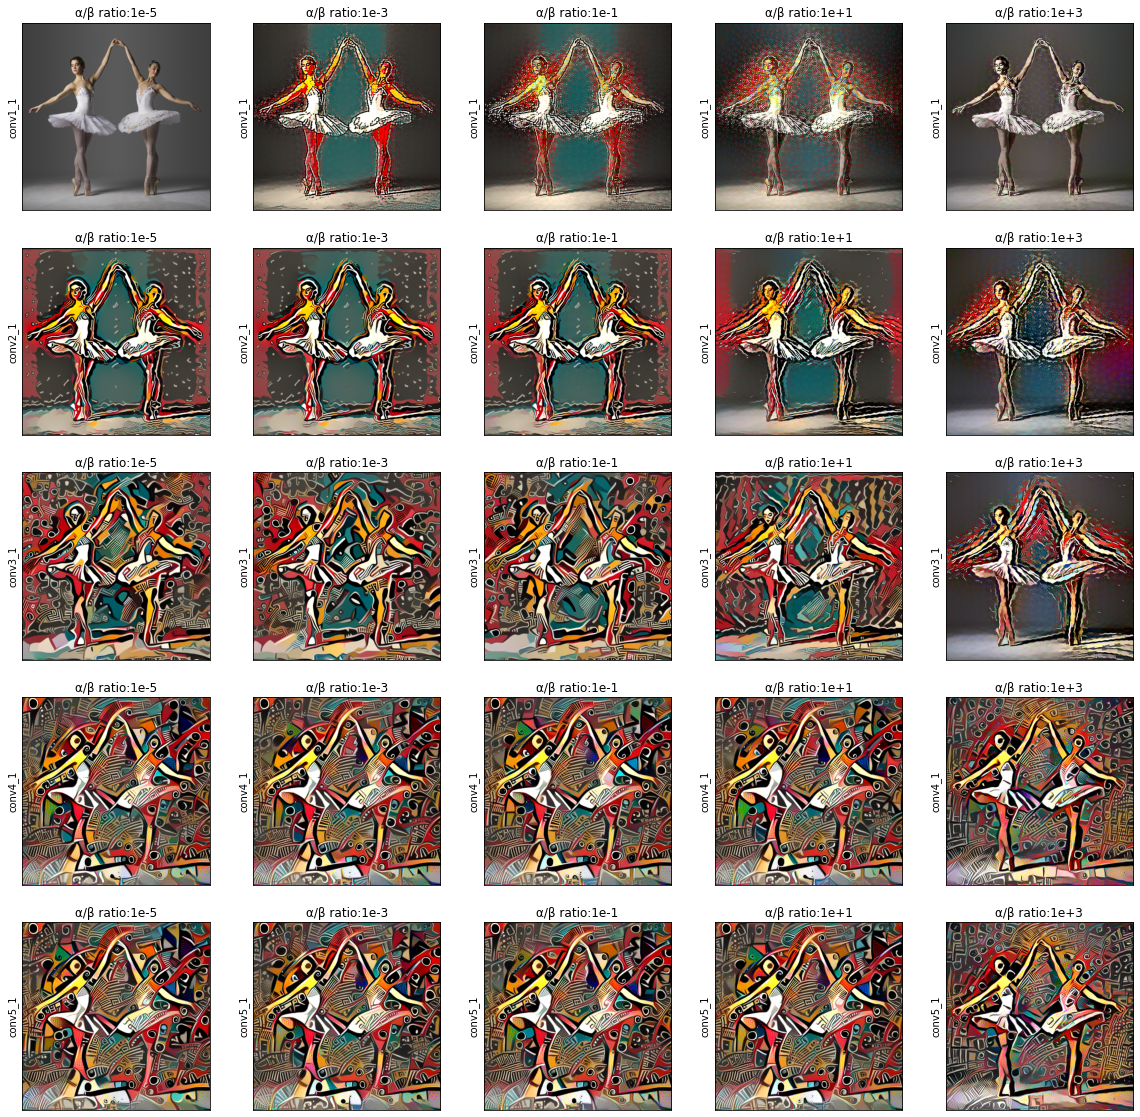

In [0]:
draw_nst_examples(picture_set = pics,
                  ratio_set = alpha_beta_ratios,
                  layers_set = style_layers_subsets)

## Comparison of results with different pooling types

In [0]:
content_set = ['/content/balley.png',
               '/content/flower.png',
               '/content/mountain.png',
               '/content/sighthound.png',
               '/content/tajmahal.png',
               '/content/tuebingen.png',
               ]

In [0]:
pool_types = ['avg', 'max']
pics = []

for content_path in content_set:
    for pool_type in pool_types:
        style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
        content_layers = ['conv4_2']

        style_paths = { '/content/style_10.jpg': 1 }
        normalize_weights(style_paths)

        imsize = 512
        style_images = [(load_img(path, imsize), relative_weight) for path, relative_weight in style_paths.items()]
        content_image = load_img(content_path, imsize)

        nst_model = get_model(path_to_pretrained=vgg_directory, pooling=pool_type)
        targets = get_targets(nst_model, style_layers, content_layers, style_images, content_image)
        loss_funcs = get_loss_funcs(style_layers, content_layers)
        loss_layers = style_layers + content_layers

        style_weight = 1e3
        content_weight = 1
        factor = 1. / len(style_layers)
        weights = [style_weight * factor] * len(style_layers) + [content_weight] * len(content_layers)

        optimImg = Variable(content_image.data.clone(), requires_grad=True).to(device)
        optimizer = optim.LBFGS([optimImg])

        img, h = run_style_transfer(model = nst_model,
                                    optim_img = optimImg,
                                    optimizer = optimizer,
                                    iter_num = 20,
                                    loss_layers = loss_layers,
                                    targets = targets,
                                    loss_funcs = loss_funcs,
                                    weights = weights,
                                    verbose = False)
        
        pics.append(img)

100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


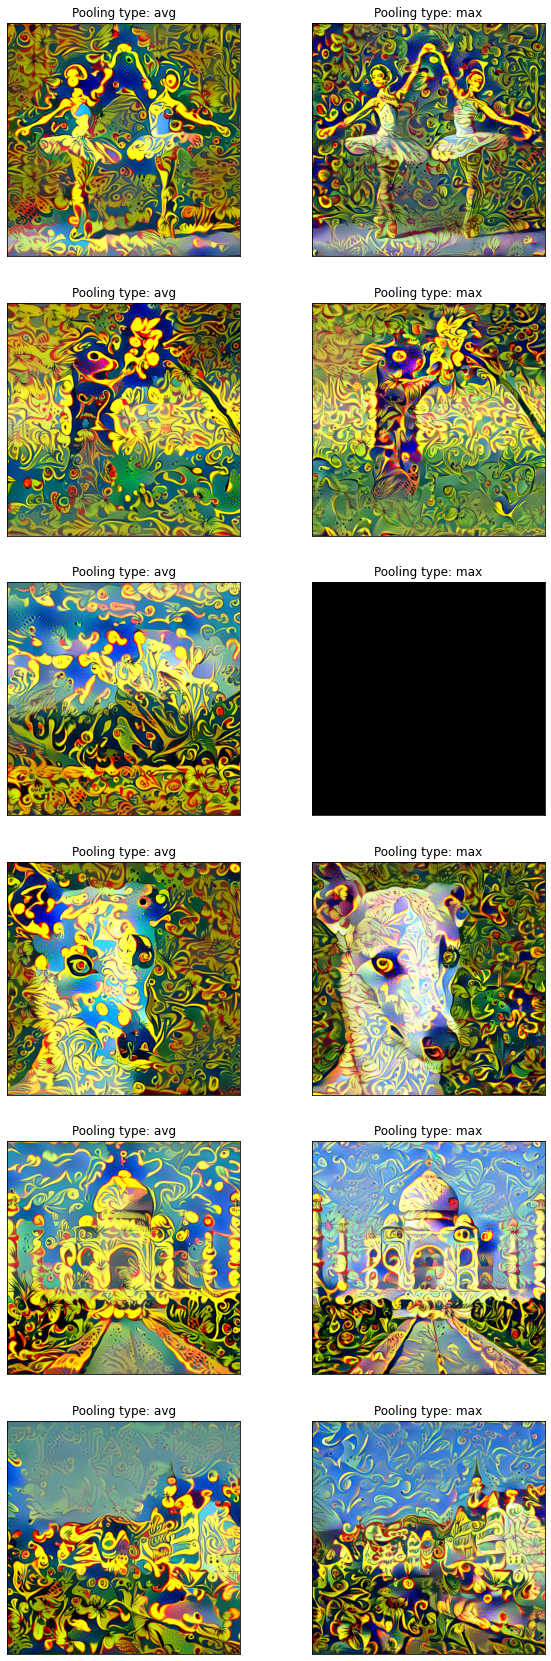

In [0]:
draw_pooling_examples(picture_set = pics,
                      pool_set = pool_types,
                      content_set = content_set,
                      scale=5)

## Transfer two styles (naive split)

In [ ]:
def get_separated_targets(model, style_layers, content_layers, style_images, content_image):
    style_targets = []
    i = 0
    for img, weight in style_images:
        if i == 0:
            style_targets.append([GramMatrix()(t[:, :, :, :int(t.size()[3]/2)]).detach() * weight for t in model(img, style_layers)])
        elif i == 1:
            style_targets.append([GramMatrix()(t[:, :, :, int(t.size()[3]/2):]).detach() * weight for t in model(img, style_layers)])
        else:
            break
        i += 1
    style_targets = [(t1, t2) for t1, t2 in zip(*style_targets)]
    content_targets = [t.detach() for t in model(content_image, content_layers)]
    targets = style_targets + content_targets
    return targets

In [ ]:
class StyleLoss(nn.Module):
    def forward(self, input, target):
        t_left, t_right = target
        G_left = GramMatrix()(input[:, :, :, :int(input.size()[3]/2)])
        G_right = GramMatrix()(input[:, :, :, int(input.size()[3]/2):])
        mse1 = F.mse_loss(G_left, t_left)
        mse2 = F.mse_loss(G_right, t_right)
        loss = (mse1 + mse2) / 2
        return loss

In [ ]:
style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
content_layers = ['conv4_2']

content_path = '/content/balley.png'
style_paths = {
               '/content/style_9.jpg': 1,
               '/content/style_5.jpg': 1,
               }
imsize = 512
normalize_weights(style_paths)
show_styles_and_weights(style_paths)

In [ ]:
style_images = [(load_img(path, imsize), relative_weight) for path, relative_weight in style_paths.items()]
content_image = load_img(content_path, imsize)

In [ ]:
nst_model = get_model(path_to_pretrained=vgg_directory, pooling='avg')
targets = get_separated_targets(nst_model, style_layers, content_layers, style_images, content_image)
loss_funcs = get_loss_funcs(style_layers, content_layers)
loss_layers = style_layers + content_layers

style_weight = 1e5
content_weight = 1
weights = [style_weight] * len(style_layers) + [content_weight] * len(content_layers)

optimImg = Variable(content_image.data.clone(), requires_grad=True).to(device)
optimizer = optim.LBFGS([optimImg])

In [ ]:
img, h = run_style_transfer(model = nst_model,
                            optim_img = optimImg,
                            optimizer = optimizer,
                            iter_num = 15,
                            loss_layers = loss_layers,
                            targets = targets,
                            loss_funcs = loss_funcs,
                            weights = weights,
                            verbose = True)